In [1]:
import numpy as np
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torch import Tensor                            # tensor node in the computation graph
import torch.nn as nn                               # neural networks
import torch.nn.functional as F                     # layers, activations and more
import torch.optim as optim                         # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms     # vision datasets, architectures & transforms
import torchvision.transforms as transforms              # composable transforms


class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def get_prediction(self, x, device):
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        return classes[self(x[None, ...].to(device)).max(1).indices]

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    
def load_model(Model_class, kwargs, file_path):
    model = Model_class(**kwargs)
    model.load_state_dict(torch.load(file_path))
    return model

In [2]:
from tqdm import tqdm, trange
import numpy as np
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torch import Tensor                            # tensor node in the computation graph
import torch.nn as nn                               # neural networks
import torch.nn.functional as F                     # layers, activations and more
import torch.optim as optim                         # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms     # vision datasets, architectures & transforms
import torchvision.transforms as transforms              # composable transforms
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [#transforms.AutoAugment(policy = transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

#scripted_transform =
batch_size = 64

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = SimpleNet().to(device)
print(model.modules)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10,20], gamma=0.1)
n_epochs = 30
save_path = os.path.join('checkpoints',"bestmodel.pt")
print(save_path)

best_accuracy = 0.0
for epoch in range(n_epochs):  # loop over the dataset multiple times
    model.train()
    
    loss_acc_train = 0
    correct_guesses_train = 0
    number_of_guesses_train = 0
    with tqdm(trainloader, desc=f"Train {epoch}", unit="batch", leave=True) as bt:
        for i, (images, labels) in enumerate(bt):
            ## Train basic classifier with gaussian data augmentation
            images, labels = (images.to(device) + torch.randn_like(images, device='cuda') * 0.45), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc_train += loss
            
            pred = outputs.max(1).indices
            correct_guesses_train += (labels == pred).sum().item()
            number_of_guesses_train += pred.size(0)
            
            bt.set_postfix(loss=loss_acc_train.item()/(i+1), accuracy=correct_guesses_train/number_of_guesses_train)
    
    model.eval()
    loss_acc_eval = 0
    correct_guesses_eval = 0
    number_of_guesses_eval = 0
    accuracy = 0
    with torch.no_grad():
        with tqdm(testloader, desc=f"Eval {epoch}", unit="batch", leave=True) as bt:
            for i, (images, labels) in enumerate(bt):
                images, labels = (images.to(device) + torch.randn_like(images, device='cuda') * 0.45), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_acc_eval += loss
                
                pred = outputs.max(1).indices
                correct_guesses_eval += (labels == pred).sum().item()
                number_of_guesses_eval += pred.size(0)
                accuracy = correct_guesses_eval/number_of_guesses_eval
                bt.set_postfix(loss=loss_acc_eval.item()/(i+1), accuracy=accuracy)
    
    if best_accuracy < accuracy:
        save_model(model, 'model.pt')        
    
    scheduler.step()


print('Finished Training')
device = torch.device("cuda")
model = SimpleNet()
model.load_state_dict(torch.load('model.pt'))
model.to(device)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
<bound method Module.modules of SimpleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>
checkpoints/bestmodel.pt


Eval 29: 100%|██████████| 157/157 [00:02<00:00, 52.84batch/s, accuracy=0.605, loss=1.13]


Finished Training


SimpleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def FGSM(model, image, attack_label, epsilon=5*1e-2):
    attacked_image = image.clone()
    attacked_image.requires_grad=True
    pred = model(attacked_image.to(device))
    criterion(pred, attack_label).backward()
    attacked_image.requires_grad=False
    attacked_image = attacked_image + epsilon*attacked_image.grad.sign()
    attacked_image.grad = None
    return attacked_image

def PGM(model, image, attack_label, epsilon=5*1e-2, delta=2*1e-2, t_max=10):
    attacked_image = image.clone()
    attacked_image = attacked_image.to(device)
    attack = torch.zeros_like(attacked_image).to(device)
    
    pred = model(attacked_image)

    for _ in range(t_max):
        attacked_image.requires_grad = True
        pred = model(attacked_image)
     
        #if pred.max(1).indices != attack_label:
        #    return attack
        criterion(pred, attack_label).backward()
        grad = attacked_image.grad
        attacked_image.grad = None
        attacked_image.requires_grad = False
        attack += delta * grad.sign()
        #if ((attack**2).sum()/(32*32*3)).sqrt() > epsilon:
        #    attack /= ((attack**2).sum()/(32*32*3)).sqrt()/epsilon
        if attack.max() > epsilon:
            attack = (attack/attack.max()) * epsilon
        if -attack.min() > epsilon:
            attack = (attack/-attack.min()) * epsilon
        
        attacked_image = image + attack
        
        attacked_image[attacked_image > 1.0] = 1.0
        attacked_image[attacked_image < -1.0] = -1.0
    
    pred = model(attacked_image)
  
    return attack


In [4]:
from tqdm import tqdm, trange
import numpy as np
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torch import Tensor                            # tensor node in the computation graph
import torch.nn as nn                               # neural networks
import torch.nn.functional as F                     # layers, activations and more
import torch.optim as optim                         # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms     # vision datasets, architectures & transforms
import torchvision.transforms as transforms              # composable transforms

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def FGSM(model, image, attack_label, criterion, epsilon=0.031):
    attacked_image = image.clone()
    attacked_image.requires_grad=True
    pred = model(attacked_image.to(device))
    criterion(pred, attack_label).backward()
    attacked_image.requires_grad=False
    attacked_image = attacked_image + epsilon*attacked_image.grad.sign()
    # attacked_image[attacked_image > 1.0] = 1.0
    # attacked_image[attacked_image < -1.0] = -1.0
    attacked_image.grad = None
    return attacked_image

def PGD(model, image, attack_label, criterion, epsilon=0.031, delta=2*1e-2, t_max=10, l2=False):
    attacked_image = image.clone()
    attacked_image = attacked_image.to(device)
    attack = torch.zeros_like(attacked_image).to(device)
    #print(attack_label)
    pred = model(attacked_image)
    #print(pred.max(1).indices)
    for _ in range(t_max):
        attacked_image.requires_grad = True
        pred = model(attacked_image)
        #print(pred.max(1).indices)
        #if pred.max(1).indices != attack_label:
        #    return attack
        criterion(pred, attack_label).backward()
        grad = attacked_image.grad
        attacked_image.grad = None
        attacked_image.requires_grad = False
        if l2:
            attack += delta * nn.functional.normalize(grad, p=2)
            # project back into the ball
            attack = epsilon * nn.functional.normalize(attack, p=2)
        else:
            attack += delta * grad.sign()
            # project back into the ball
            if attack.max() > epsilon:
                attack = (attack/attack.max()) * epsilon
            if -attack.min() > epsilon:
                attack = (attack/-attack.min()) * epsilon
        
        attacked_image = image + attack
        
        #attacked_image[attacked_image > 1.0] = 1.0
        #attacked_image[attacked_image < -1.0] = -1.0
    
    #pred = model(attacked_image)
    #print(pred.max(1).indices)
    return attacked_image

In [5]:
import torch 
from scipy.stats import norm, binom_test
from statsmodels.stats.proportion import proportion_confint

##to do : check hyperparameter alpha, sigma, n, n0 

class Smoothed_classifier(nn.Module):

  def __init__(self, base_classifier, num_classes, sigma):
        """
        :param base_classifier: maps from [batch x channel x height x width] to [batch x num_classes]
        :param num_classes:
        :param sigma: the noise level hyperparameter
        """
        super().__init__()
        self.base_classifier = base_classifier
        self.num_classes = num_classes
        self.sigma = sigma
        self.ABSTAIN = -1

  def forward(self,x):
    return self.base_classifier.forward(x)

  def predict(self, x, n, alpha):
    """ predict  """
    samples = self.sample_noisy(x,n,self.sigma)
    counts = self.get_class_counts(samples)
    sorted, indices = torch.sort(counts, descending = True)
    c_a,c_b = indices[0].item(), indices[1].item()
    
    n_a,n_b = sorted[0].item(), sorted[1].item()

    if self.get_binom_pValue(n_a,n_a + n_b ,p = 0.5) <= alpha :
      return c_a
    else : 
      return self.ABSTAIN
  

  def certify(self,x,n0,n,alpha):
    """ certify """
    small_sample = self.sample_noisy(x,n0,self.sigma)
    small_predict = self.get_class_counts(small_sample)
    _, indices = torch.sort(small_predict, descending = True)
    c_a = indices[0].item()
    sample = self.sample_noisy(x,n,self.sigma)
    big_predict = self.get_class_counts(sample)
    
    n_a = big_predict[c_a].item()
    p_aBar = self.get_lower_conf_bound(n_a,n,alpha)

    if p_aBar > 0.5 :
      radius = self.sigma * norm.ppf(p_aBar)
      return (c_a, radius)
    else:
      return self.ABSTAIN, 0.0

  def sample_noisy(self,x,n,sigma):
    """ x : original image
        n : batch size of the generated samples """
    noise = torch.randn_like(x, device='cuda') * sigma 
    samples = x.repeat(n,1,1,1).to('cuda') + noise 
    return samples
    


  def get_class_counts(self,samples):
   
    """ samples : tensor with noisy copies of an image """
    with torch.no_grad():
      predictions = self.base_classifier(samples).argmax(1)
   
    return torch.bincount(predictions,minlength=self.num_classes)
    

  def get_binom_pValue(self,n_a,n,p = 0.5):
    """ n_a : number of images classified with class A
        n : batch size of the generated samples 
        p :                                           """
    return binom_test(n_a, n,p )

  
  def get_lower_conf_bound(self,n_a,n,alpha):
    """ n_a : number of images classified with class A
        n : batch size of the generated samples 
        alpha : """
    return  proportion_confint(n_a, n, alpha=2 * alpha, method="beta")[0]


Files already downloaded and verified
170498071/170498071 [==============================] - 4s 0us/step


TypeError: ignored

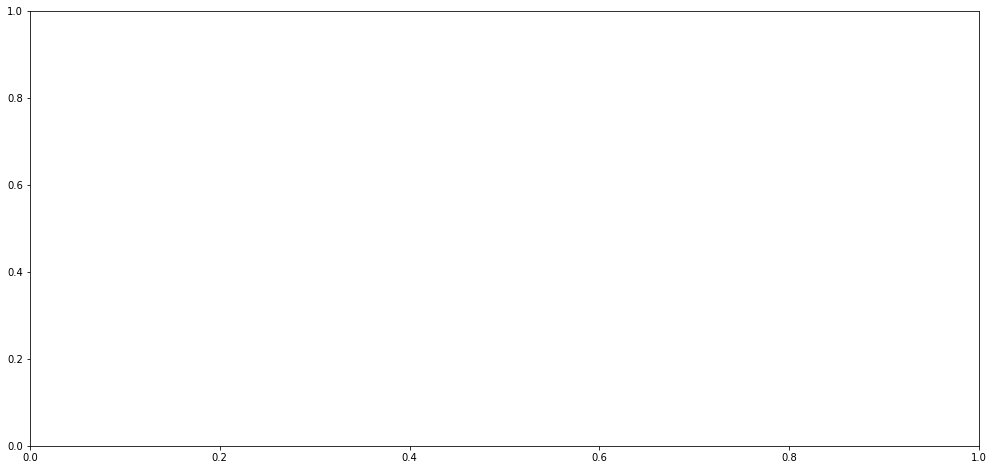

In [ ]:

smoothed_classifier = Smoothed_classifier(model,len(classes),0.12)
test_images = iter(testset)
image, label = next(test_images)
image = image.reshape(1,3,32,32)
samples = smoothed_classifier.sample_noisy(image, 2,0.12)
#counts = smoothed_classifier.get_class_counts(samples)
#predictions = smoothed_classifier.predict(image,1000,0.001)
#print(predictions)
#certifications = smoothed_classifier.certify(image,100,10000,0.001)
#print(certifications)

show_image = transforms.ToPILImage()(image[0].to('cpu')/2 +0.5)
#image = image[None, ...]
pred = model(image.to(device))
plt.imshow(show_image)

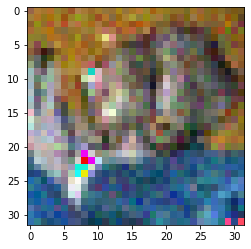

In [ ]:
show_image = transforms.ToPILImage()(samples[0].to('cpu')/2 + 0.5)
plt.imshow(show_image)

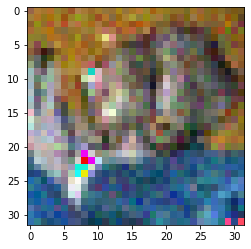

In [ ]:
show_image = transforms.ToPILImage()(samples[1].to('cpu')/2 + 0.5)
plt.imshow(show_image)

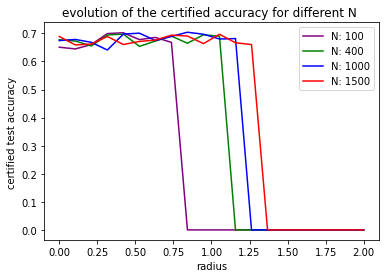

In [ ]:
from scipy.stats.distributions import zipf
import matplotlib.pyplot as plt

smoothed_classifier = Smoothed_classifier(model,len(classes),0.5)
#test_images = iter(testset)
radius = np.linspace(0.0,2,20)

for n,color in zip([100,400,1000,1500],['purple','green','blue','red']):
  accuracy = []
  for r in radius:
    test_images = iter(testset)
    nb_correctly_predicted = 0
    nb_abstain = 0
    for i in range (1,len(testset)):
      image,label = next(test_images)
    
      prediction,rad = smoothed_classifier.certify(image,100,n,0.001)
      if prediction == label and rad >= r :
        nb_correctly_predicted += 1
      if prediction == -1 :
        nb_abstain += 1
      if i == 300:
        break
    acc = nb_correctly_predicted/(300 - nb_abstain)    
    #acc = nb_correctly_predicted/(len(testset) - nb_abstain)
    accuracy.append(acc)
  plt.title("evolution of the certified accuracy for different N ")
  plt.xlabel("radius")
  plt.ylabel("certified test accuracy ")
  plt.plot(radius, accuracy,color,label=f'N: {n}')
  plt.legend()


plt.show() 



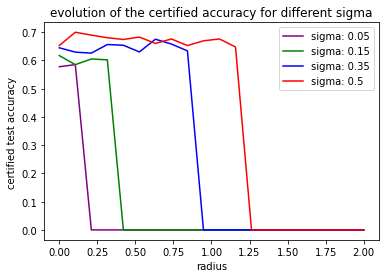

In [ ]:
import matplotlib.pyplot as plt

smoothed_classifier = Smoothed_classifier(model,len(classes),0.5)
#test_images = iter(testset)
radius = np.linspace(0.0,2,20)

for sigma,color in zip([0.05,0.15,0.35,0.5],['purple','green','blue','red']):
  accuracy = []
  smoothed_classifier = Smoothed_classifier(model,len(classes),sigma)
  for r in radius:
    test_images = iter(testset)
    nb_correctly_predicted = 0
    nb_abstain = 0
    for i in range (1,len(testset)):
      image,label = next(test_images)
    
      prediction,rad = smoothed_classifier.certify(image,100,1000,0.001)
      if prediction == label and rad >= r :
        nb_correctly_predicted += 1
      if prediction == -1 :
        nb_abstain += 1
      if i == 300:
        break
    acc = nb_correctly_predicted/(300 - nb_abstain)    
    #acc = nb_correctly_predicted/(len(testset) - nb_abstain)
    accuracy.append(acc)
  plt.title("evolution of the certified accuracy for different sigma")
  plt.xlabel("radius")
  plt.ylabel("certified test accuracy ")
  plt.plot(radius, accuracy,color,label=f'sigma: {sigma}')
  plt.legend()


plt.show() 



In [12]:
acc_basic_simple = 0
acc_fgsm_simple = 0
acc_pgm_simple = 0
acc_basic_smooth = 0
acc_fgsm_smooth = 0
acc_pgm_smooth = 0
test_images = iter(testset)

smoothed_classifier = Smoothed_classifier(model,len(classes),0.5)

for i in range (1,len(testset)):
  try :
    image,label = next(test_images)
  except StopIteration :
    break
  pred_basic_smooth = smoothed_classifier.predict(image,100,0.001)
  
  image = image[None, ...]
  pred_basic_simple = model(image.to(device)).argmax(1)
  fgsm_attack = FGSM(model, image, torch.tensor([label]).to(device),criterion = criterion)
  pgm_attack = PGD(model, image.to(device), torch.tensor([label]).to(device),criterion = criterion,epsilon=0.045,delta=0.5,l2=True)
  pred_fgsm_simple = smoothed_classifier.base_classifier(fgsm_attack.to(device)).argmax(1)
  pred_pgm_simple = smoothed_classifier.base_classifier(pgm_attack.to(device)).argmax(1)
  pred_fgsm_smooth = smoothed_classifier.predict(fgsm_attack,100,0.001)
  pred_pgm_smooth = smoothed_classifier.predict(pgm_attack,100,0.001)
  if pred_basic_smooth == label :
    acc_basic_smooth += 1
  if pred_fgsm_smooth == label :
    acc_fgsm_smooth += 1
  if pred_pgm_smooth == label :
    acc_pgm_smooth += 1

  if pred_basic_simple == label :
    acc_basic_simple += 1
  if pred_fgsm_simple == label :
    acc_fgsm_simple += 1
  if pred_pgm_simple == label :
    acc_pgm_simple += 1

print("Accuracy of the basic classifier")
print(f'accuracy with basic images : {100*acc_basic_simple/len(testset)}%')
print(f'accuracy with fgsm images : {100*acc_fgsm_simple/len(testset)}%')
print(f'accuracy with pgm images : {100*acc_pgm_simple/len(testset)}%')
print("--------------------------------------------------------------------")
print("Accuracy of the smooth classifier")
print(f'accuracy with basic images : {100*acc_basic_smooth/len(testset)}%')
print(f'accuracy with fgsm images : {100*acc_fgsm_smooth/len(testset)}%')
print(f'accuracy with pgm images : {100*acc_pgm_smooth/len(testset)}%')


Accuracy of the basic classifier
accuracy with basic images : 62.16%
accuracy with fgsm images : 26.17%
accuracy with pgm images : 25.16%
--------------------------------------------------------------------
Accuracy of the smooth classifier
accuracy with basic images : 59.14%
accuracy with fgsm images : 38.4%
accuracy with pgm images : 39.8%


In [ ]:
acc_basic = 0
acc_fgsm = 0
acc_pgm = 0
test_images = iter(testset)

for i in range (1,len(testset)):
  try :
    image,label = next(test_images)
  except StopIteration :
    break
  pred_basic = smoothed_classifier.predict(image,100,0.001)
  image = image[None, ...]
  fgsm_attack = FGSM(model, image, torch.tensor([label]).to(device))
  pgm_attack = PGM(model, image.to(device), torch.tensor([label]).to(device))
  pred_fgsm = smoothed_classifier.predict(fgsm_attack,100,0.001)
  pred_pgm = smoothed_classifier.predict(pgm_attack,100,0.001)
  if pred_basic == label :
    acc_basic += 1
  if pred_fgsm == label :
    acc_fgsm += 1
  if pred_pgm == label :
    acc_pgm += 1

print(f'accuracy with basic images : {100*acc_basic/len(testset)}%')
print(f'accuracy with fgsm images : {100*acc_fgsm/len(testset)}%')
print(f'accuracy with pgm images : {100*acc_pgm/len(testset)}%')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
tensor([[-2.2272, -4.0039,  2.0736,  3.5483,  1.4372,  3.2378,  0.5831,  1.0654,
         -2.6471, -3.0329]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([3], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[-0.2685, -1.8899,  3.6056,  0.9293,  0.8659,  0.3177,  1.1793, -0.7908,
         -2.0504, -1.8674]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.6156, -1.1331,  2.4583,  0.8156,  0.9046,  0.1563,  1.5754, -0.7663,
         -1.9579, -1.3712]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9511, -0.5980,  1.4456,  0.7267,  1.0876, -0.0168,  2.0242, -0.7240,
         -1.9313, -0.9746]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.2341, -0.4714,  1.1122,  0.7233,  1.1432,  0.0218,  2.2626, -0.6679,
         -1.9844, -0.8116]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.3318, -0.4941,  1.1250,  0.7300,  1.1415,  0.0576,  2.3680

In [ ]:
### approximation of certified accuracy : defined as the fraction of the test set which CERTIFY classifies correctly (without abstaining) and certifies robust with a radius R sup to r
## TO DO Plots certified accuracy en ordonnées, radius (r) en abscisse ( plot avec et sans mecanisme de defense)
## ## TO DO Plots certified accuracy en ordonnées, radius (r) en abscisse ( tester differentes valeurs de n)

